# Udacity's Machine Learning Engineer Nanodegree

## Unsupervised Learning

## Project: Creating Customer Segments

## Getting Started

In this project, analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, I will begin exploring the data through visualizations and code to understand how each feature is related to the others. I will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

In [5]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, I chose **three** indices of my choice and added them to the `indices` list which will represent the customers to track.

In [6]:
# Choose three indices to sample from the dataset
indices = [26, 126, 349]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9898,961,2861,3151,242,833
1,19219,1840,1658,8195,349,483
2,5981,14641,20521,2005,12218,445


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

___1<sup>st</sup> Sample Record (index = 26):___

| Category | Purchase   |  Range  |
|------|------|-------|
|   Fresh  | 9898| 50 - 75 %  |
|   Milk  | 961| < 25 %  |
|   Grocery  | 2861| 25 - 50 %  |
|   Frozen  | 3151| 50 - 75 %  |
|   Detergents_Paper  | 242| < 25 %  |
|   Delicatessen  | 833| 25 - 50 %  |

This customer purchases __high__ amounts of `'Fresh'` & `'Frozen'` (above the median values) compared to any other category. So, this seems to be a __restaurant__.

---

___2<sup>nd</sup> Sample Record (index = 126):___

| Category | Purchase   |  Range  |
|------|------|-------|
|   Fresh  | 19219| > 75 %  |
|   Milk  | 1840| ~ 25 %  |
|   Grocery  | 1658| < 25 %  |
|   Frozen  | 8195| > 75 %  |
|   Detergents_Paper  | 349| ~ 25 %  |
|   Delicatessen  | 483| ~ 25 %  |

This customer, too, spends a lot on `'Fresh'` & `'Frozen'`. In fact, it spends more than the customer represented by the 1<sup>st</sup> sample record, and is therefore a bigger establishment, like a __hotel__.

---

___3<sup>rd</sup> Sample Record (index = 349):___

| Category | Purchase   |  Range  |
|------|------|-------|
|   Fresh  | 5981| 25 - 50 %  |
|   Milk  | 14641| > 75 %  |
|   Grocery  | 20521| > 75 %  |
|   Frozen  | 2005| 50 -75 %  |
|   Detergents_Paper  | 12218| > 75 %  |
|   Delicatessen  | 445| ~ 25 %  |

This customer spends the maximum amount on `'Grocery'`, `'Detergents_Paper'` & `'Milk'` (above the 3<sup>rd</sup> quartile mark). It spends the lowest on `'Delicatessen'`, followed by `'Frozen'` & `'Fresh'`. So, this seems to be a __supermarket__/__wholesale retailer__.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Frozen'], axis=1)

# Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Frozen'], test_size=0.25, random_state=1)

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print(score)

-0.6794458434


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score?
* Is this feature necessary for identifying customers' spending habits?

**Answer:**

I attempted to predict the __`'Frozen'`__ feature.

The reported prediction score(__R<sup>2</sup>__) is __always negative__.

The coefficient of determination, R<sup>2</sup>, is negative, which implies that this feature is hard to predict using the other features. Therefore, this feature is __necessary__ for identifying customers' spending habits.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

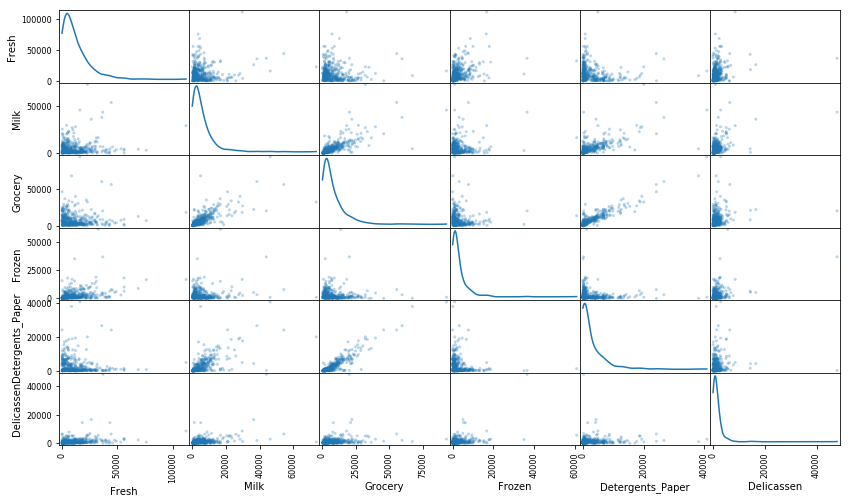

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Answer:**

The above scatter matrix reveals the following points:

* Distribution of every feature is right-skewed (positive skewness)
* Outliers exist in almost every scatter plot
* Large number of data points near 0
* Scatter plots of __Milk, Grocery__ and __Detergents_Paper__ show _positive correlation_. Lets print their pair-wise correlations and visualize them using a heatmap.

In [5]:
print("Corr b/w Milk & Grocery:\t\t{0:.3f}".format(data['Milk'].corr(data['Grocery'])))
print("Corr b/w Grocery & Detergents_Paper:\t{0:.3f}".format(data['Grocery'].corr(data['Detergents_Paper'])))
print("Corr b/w Detergents_Paper & Milk:\t{0:.3f}".format(data['Detergents_Paper'].corr(data['Milk'])))

Corr b/w Milk & Grocery:		0.728
Corr b/w Grocery & Detergents_Paper:	0.925
Corr b/w Detergents_Paper & Milk:	0.662


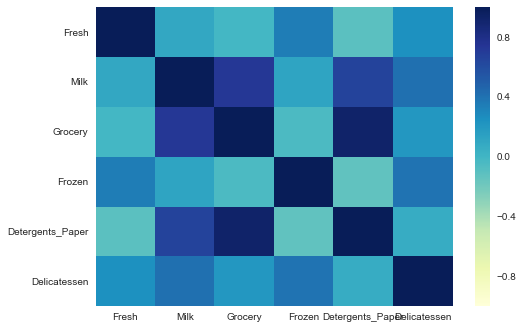

In [6]:
import seaborn as sns

sns.set()
sns.heatmap(data.corr(), cmap="YlGnBu")

The above heatmap supports our theory that correlation exists between `'Milk'`, `'Grocery'` & `'Detergents_Paper'`.

The feature `'Frozen'` that I had earlier attempted to predict is colored light blue (_sometimes light green_) in the above heatmap, thus confirming no correlation with any of the other features, which is similar to the conclusions that I earlier drew about the relevance of this feature.

## Data Preprocessing
In this section, I will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that the results obtained from my analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

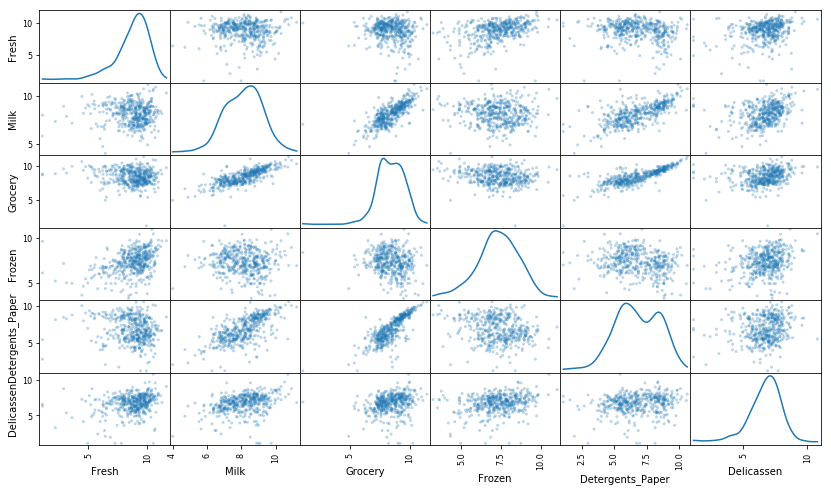

In [9]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

In [10]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.200088,6.867974,7.958926,8.055475,5.488938,6.725034
1,9.863655,7.517521,7.413367,9.011279,5.855072,6.180017
2,8.696343,9.591581,9.929204,7.603399,9.410666,6.098074


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [11]:
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    feature_outliers_data = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(feature_outliers_data)
    
    outliers += feature_outliers_data.index.tolist()

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

**Answer:**

Let's print the count and the indexes of those data points which are outliers for more than 1 feature.

In [12]:
print("A total of {} data points are considered as outliers".format(len(set(outliers))))
outlier_dups = set([x for x in outliers if outliers.count(x) > 1])
print("\nOut of them, {} data points are considered outliers for more than one feature".format(len(outlier_dups)))
print("\nOutlier Index\tFeature Count")
print("-------------\t-------------")
for idx in outlier_dups:
    print("{}\t\t{}".format(idx, outliers.count(idx)))

# Reassigning outliers with the selected 5 indices
outliers = list(outlier_dups)

A total of 42 data points are considered as outliers

Out of them, 5 data points are considered outliers for more than one feature

Outlier Index	Feature Count
-------------	-------------
128		2
65		2
66		2
75		2
154		3


I would not be removing all the 42 data points (_considered as outliers_) from the dataset. Rather, I plan to remove those 5 data points that are considered outliers for more than one feature.

___Reason_:__ K-means clustering algorithm updates the cluster centroids by taking the mean of all data points assigned to that centroid's cluster. When all the points are packed nicely together, the average makes sense. However, when there are outliers, this can affect the average calculation of the whole cluster. As a result, this will push the cluster center closer to the outlier.

Having said that, I would avoid removing those data points that are ouliers for ONLY 1 feature, because:
* they constitue almost 9% of the dataset
* removing them may result in loss of necessary information to correctly classify customer behavior

In [147]:
# Remove the outliers

print("Removing data points that are outliers for more than one feature")
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
print("Shape of the good_data dataset: ", good_data.shape)

Removing data points that are outliers for more than one feature
Shape of the good_data dataset:  (435, 6)


## Feature Transformation
In this section I will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, I will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

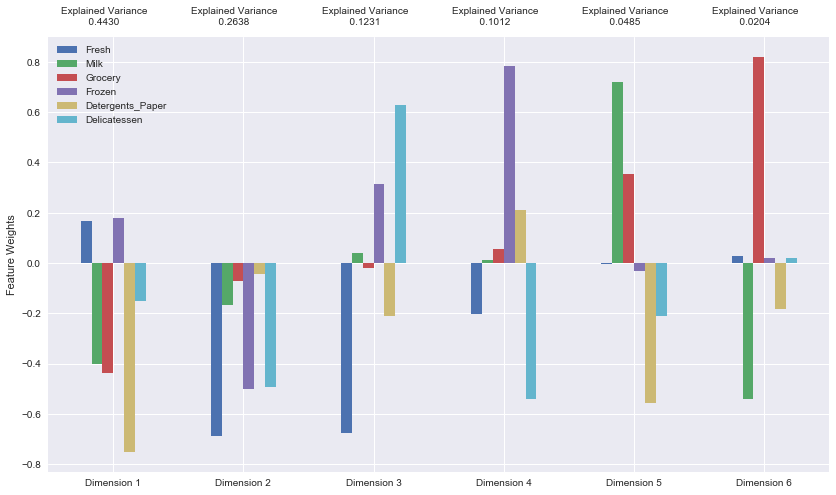

In [148]:
# Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca = PCA(n_components=6).fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [125]:
display(pca_results)
print("\nCumulative Proportion of Variance")
print("----------------------------------")
display(pca_results['Explained Variance'].cumsum())

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197



Cumulative Proportion of Variance
----------------------------------


Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Answer:**

* __70.68%__ of the variance in the data is explained by the __first and second__ principal components
* __93.11%__ of the variance in the data is explained by the __first four__ principal components


* __Dimension 1 Analysis - PC1__
    * The first principal component strongly represents 3 features - __'Milk'__, __'Grocery'__ & __'Detergents_Paper'__. _This also supports the correlation among these 3 features that was earlier established_.
    * It reveals high variance in `'Detergents_Paper'`, followed by `'Grocery'` and `'Milk'`.
    * An increase in PC1 is associated with high purchase cost for `'Detergents_Paper'` followed by `'Grocery'` and `'Milk'`.
    * This principal component can be interpreted as being a __Supermarket/Wholesale Retailer__.
    

* __Dimension 2 Analysis - PC2__
    * The second principal component strongly represents 3 features - __'Fresh'__, __'Frozen'__ & __'Delicatessen'__.
    * It reveals high variance in `'Fresh'`, followed by `'Frozen'` and `'Delicatessen'`. _The features of PC1 show very minimal impact on this PC_
    * An increase in PC2 is associated with high purchase cost for `'Fresh'` followed by `'Frozen'` and `'Delicatessen'`.
    * Looking at its associations, this principal component can be interpreted as being a __Hotel/Restaurant/Cafe__.
    

* __Dimension 3 Analysis - PC3__
    * The first principal component strongly represents 2 features - __'Fresh'__ & __'Delicatessen'__.
    * It puts huge emphasis on `'Fresh'`, followed by `'Delicatessen'`.
    * Due to its largest association with `Fresh` products followed by `Delicatessen`, this principal component can be interpreted as being a __Deli__ serving fresh & healthy foods.
    

* __Dimension 4 Analysis - PC4__
    * The first principal component strongly represents 2 features - __'Frozen'__ & __'Delicatessen'__.
    * An increase in PC4 is associated with high purchase cost for `'Frozen'` followed by `'Delicatessen'`.
    * Looking at its strong association with `'Frozen'` products, this PC seems like a __Restaurant/Cafe__.
    
_References:_
* _https://onlinecourses.science.psu.edu/stat505/node/54/_
* _https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/_

### Observation
The code below will help us see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions.

In [126]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.9083,-0.3765,0.1924,0.1502,-0.3852,0.5367
1,1.9745,-1.1263,-0.3393,1.1157,-0.2356,-0.3004
2,-3.0662,-0.2561,-0.7621,1.2047,0.2324,-0.0695


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [149]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [128]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.9083,-0.3765
1,1.9745,-1.1263
2,-3.0662,-0.2561


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

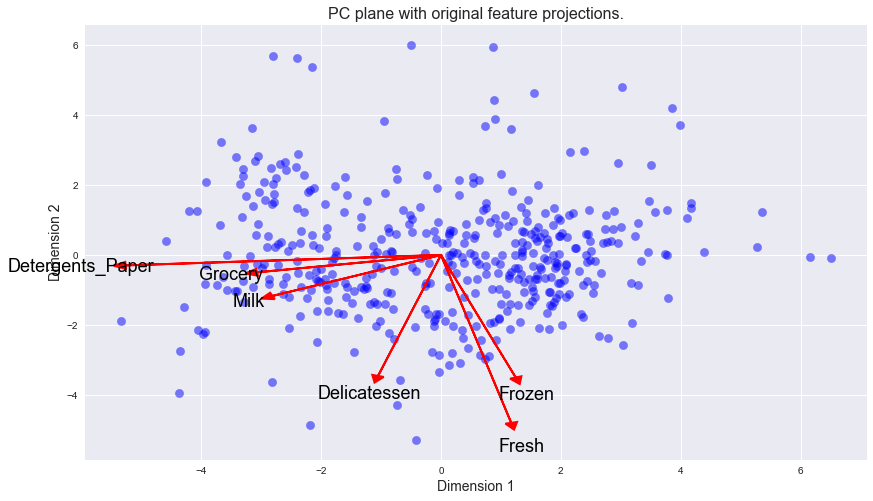

In [150]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

**Answer:**

* __`'Detergents_Paper'`__, __`'Grocery'`__ & __`'Milk'`__ are the most strongly correlated features with the first component
* __`'Delicatessen'`__, __`'Fresh'`__ & __`'Frozen'`__ are associated with the second component
* __Yes__, these observations agree with the `pca_results` plot obtained earlier

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

**Answer:**

* ___K-means advantages:___

    * Simple and easy to implement
    * Computationally faster - With a large number of variables, K-Means may be computationally faster than hierarchical	clustering (_if K is small_)
    * Produce tighter clusters
    * Easy to interpret the clustering results
    * An instance can change cluster (_move to another cluster_) when the centroids are recomputed
    
    
* ___Gaussian Mixture Model (GMM) advantages:___

    * Works well for elongated distribution of points in a cluster, instead of spherical as in k-means. As a result, cluster assignment is much more flexible in GMM than in k-means.
    * Soft-clustering (sample membership of multiple clusters) - useful when you want to classify data points/samples and you want each data point to be part of multiple categories
    * Cluster shape flexibility - cluster can contain another cluster inside it


* The wholesale customer data set have data points that are part of multiple categories (_membership across more than 1 category_). A soft-clustering algorithm like GMM seems to be more appropriate.


_References:_  
http://stp.lingfil.uu.se/~santinim/ml/2016/Lect_10/10c_UnsupervisedMethods.pdf  
https://www.researchgate.net/post/Why_do_we_often_use_a_GMM_approach  
https://stats.stackexchange.com/questions/27736/when-should-one-consider-using-gmm

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [151]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

n_clusters_range = range(2, 21)

print("Clusters\tSilhouette Score")
print("--------\t----------------")

for n_clusters in n_clusters_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print("{}\t\t{:.3f}".format(n_clusters, score))

Clusters	Silhouette Score
--------	----------------
2		0.422
3		0.374
4		0.330
5		0.242
6		0.284
7		0.338
8		0.319
9		0.318
10		0.326
11		0.318
12		0.334
13		0.250
14		0.262
15		0.252
16		0.331
17		0.307
18		0.319
19		0.325
20		0.287


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

* The silhouette score for __2 to 20 clusters__ are reported in the above table
* The silhouette score for __2 clusters__ is the __best (_0.422_)__

### Cluster Visualization

In [152]:
# Running the clustering algorithm for 2 clusters
clusterer = GaussianMixture(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

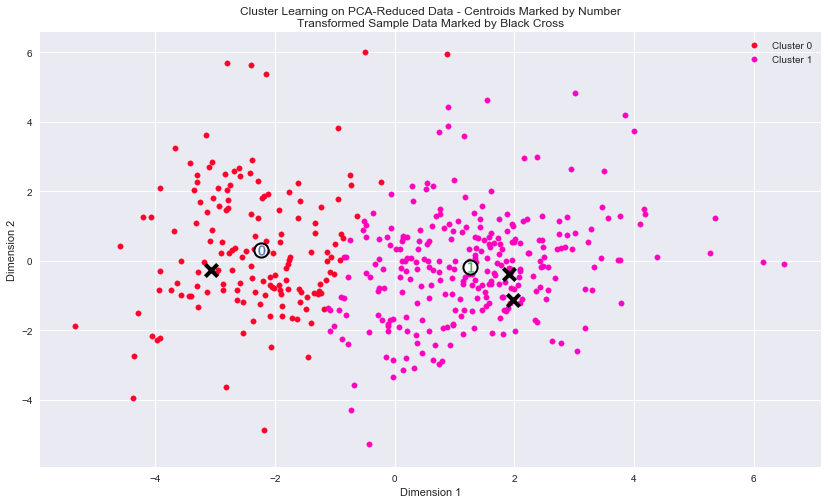

In [153]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [154]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3567.0,7860.0,12249.0,873.0,4713.0,966.0
Segment 1,8939.0,2108.0,2758.0,2073.0,352.0,730.0


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Answer:**

___Segment 0___
* Considerably low values for `'Fresh'` & `'Frozen'` (closer to their 1<sup>st</sup> quartiles)
* Very high values for `'Milk'`, `'Grocery'` & `'Detergents_Paper'` (_way above their mean values_)

This customer segment best identifies with __Supermarkets__/__Wholesale Retailers__.

-----
___Segment 1___
* Low purchase cost of `'Milk'`, `'Grocery'` & `'Detergents_Paper'`
* High values for `'Fresh'` & `'Frozen'` (_above their median values_)

This customer segment best identifies with __Hotels__/__Restaurants__/__Cafes__.

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

In [155]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


In [286]:
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9898,961,2861,3151,242,833
1,19219,1840,1658,8195,349,483
2,5981,14641,20521,2005,12218,445


**Answer:**

___Sample point 0___:  
Best represented by __Segment 1__ (__Hotels__/__Restaurants__/__Cafes__). This is __consistent__ with its earlier prediction of being a restaurant. 

___Sample point 1___:  
Best represented by __Segment 1__ (__Hotels__/__Restaurants__/__Cafes__). This is __consistent__ with its earlier prediction of being a hotel.

___Sample point 2___:  
Best represented by __Segment 0__ (__Supermarkets__/__Wholesale Retailers__). This is __consistent__ with its earlier prediction of being a supermarket. 

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

___<u>Segment 0 (Supermarkets/Wholesale Retailers):</u>___  
Compared to the other product categories, this segment of customers purchase more of `'Milk'`, `'Grocerey'` & `'Detergents_paper'`. Now, these product categories have a good shelf life and need not be delivered more frequently. Due to a considerably lower impact, this segment is more likely to ___react positively___ if the delivery service is reduced from 5 days a week to 3 days a week.

___<u>Segment 1 (Hotels/Restaurants/Cafes):</u>___    
Customers belonging to this segment purchase more of `'Fresh'` & `'Frozen'` products. Though `'Frozen'` products can be stocked & stored, `'Fresh'` products need to be delivered more frequently in order for their freshness to be retained. Otherwise, they may see a decline in the sale of their `'Fresh'` products. Obviously, this segment is more likely to ___react negatively___ if they `'Fresh'` products are delivered less frequently to them (i.e. delivery service is reduced from 5 days a week to 3 days a week).

___Distributor's Plan of Action___:  
To minimise the overall impact on customers, the wholesale distributor can hedge the risks by ___running A/B tests on one segment at a time___ and keep the other segment unaffected. As a course of action, it can ___first test the customers of Segment 0___ (_by splitting them up in 2 groups_) who seems more likely to react positively to the reduced frequency of delivery service. The test results (_variation in the spending amounts of the 2 groups of Segment 0_) thus received, will enable the distributor to arrive at a decision.  
While performing the test on ___Segment 1___, I think the distributor can strategise better by segregating customers of this segment in 2 groups based on their establishment size (_big/small_). Customers with bigger establishments, like hotels/big restaurants with more footfalls, are more likely to have better storage solutions for `'Fresh'` produce. So, the distributor can implement the change in delivery service (i.e from 5 days a week to 3 days a week) for such type of customers. On the other hand, the remaining customers (_i.e. smaller establishments like cafes/delis_) can continue with the same delivery service (i.e. 5 days a week).

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Answer:**

The wholesale distributor can use any supervised learner (_classification algorithms like SVM, Naive Bayes etc._) to train on the original customers, having the ___'Customer Segment'___ as the target variable. As we know, Customer Segment can assume 2 values only, 0 and 1.

This trained learner can then use the new customers' estimated product spending to label them (_i.e. predict their segments_).

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

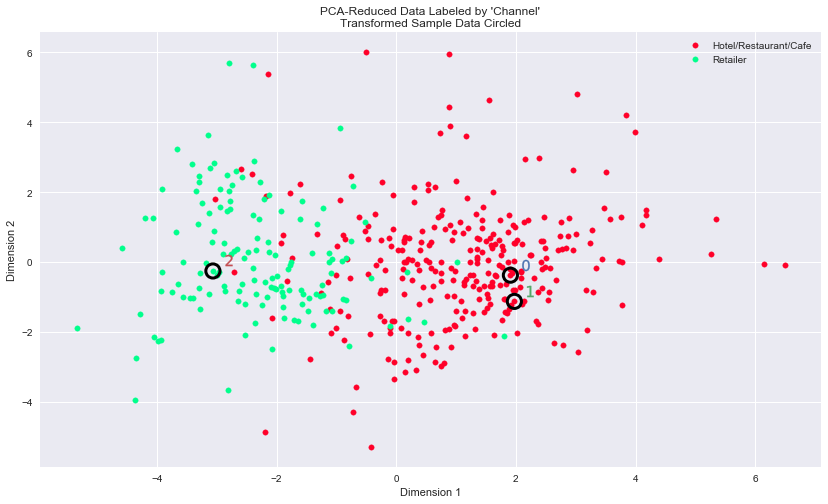

In [177]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

* Not only the chosen number of clusters (_i.e. 2_) is the same as the number of channels (_'Hotel/Restaurant/Cafe'_ & _'Retailer'_), but also the k-means clustering alogorithm is largely consistent with the underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers.


* ___Yes___; the customers falling at the extreme left or at the extreme right of the above distribution can be purely classified as _'Retailers'_ or _'Hotels/Restaurants/Cafes'_.


* ___Mostly, Yes___ (_except a few customers falling in the middle of the distribution_); these classifications are consistent with our previous definitions, where we predicted the customers on the left hand side of the distribution (_marked in the above distribution with yellow dots_) as _'Supermarkets/Wholesale Retailers'_ and the customers on the right hand side of the distribution (_marked in the above distribution with red dots_) as _'Hotels/Restaurants/Cafes'_.

> **END OF PROJECT**